60000
Data(x=[75, 1], edge_index=[2, 1260], y=[1], pos=[75, 2])


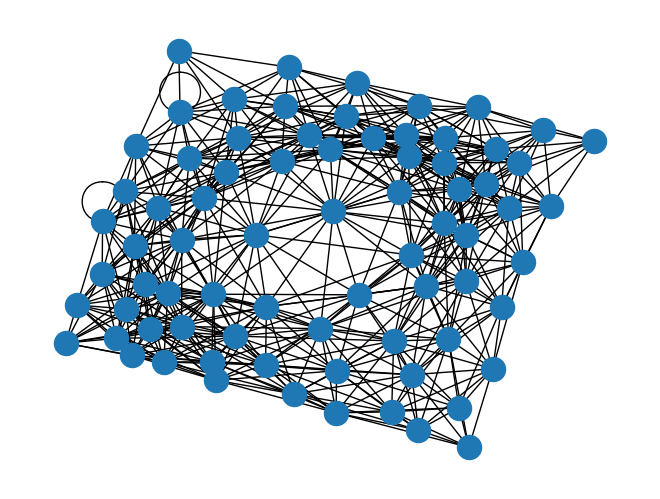

In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MNISTSuperpixels

data = MNISTSuperpixels(root='.')


print(data.len())

# Take one and visualize

x = data[1]
print(x)
from torch_geometric.utils import to_networkx
import networkx as nx

x = to_networkx(x, to_undirected=True)
nx.draw(x)



Visualizar embeddings

Index(['labels', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '118', '119', '120', '121', '122', '123', '124', '125', '126', '127'],
      dtype='object', length=129)
(48000, 128)


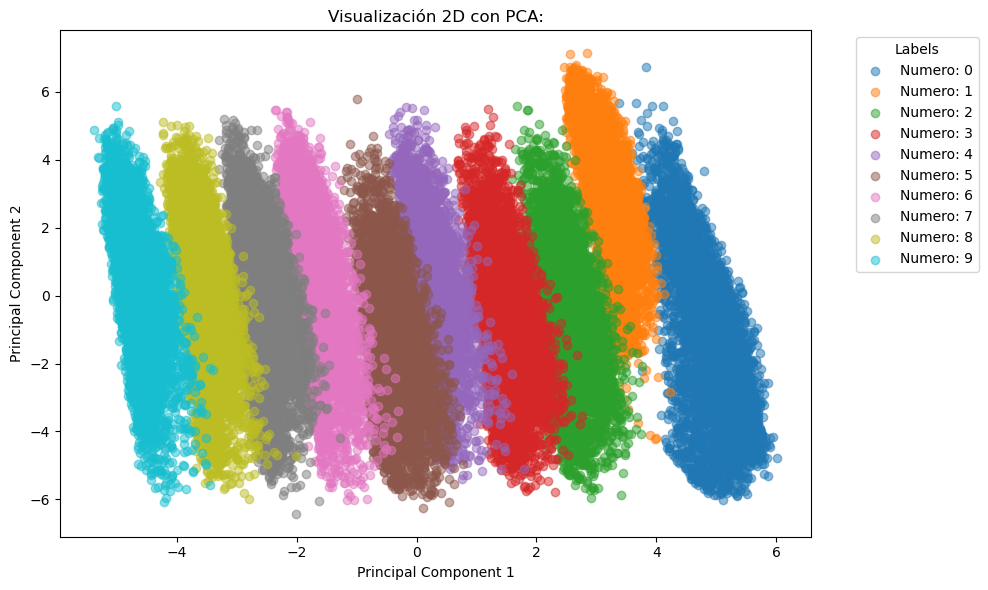

In [3]:
# Leer csv
import pandas as pd
df = pd.read_csv("vectors.csv")
print(df.columns)
#print(df.head)

#Visualize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

labels = df['labels']
data = df.iloc[:, 1:129]
print(data.shape)
data = df.to_numpy()

"""import torch
    
df = torch.load('train_embeddings.pt')
data = df['embeddings'].numpy()
labels = df['labels'].numpy()"""

# Step 1: Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Step 2: Create a scatterplot

plt.figure(figsize=(10, 6))

# Get unique labels and assign a color to each
unique_labels = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Use a colormap like 'tab10'

for label, color in zip(unique_labels, colors):
    plt.scatter(
        reduced_data[labels == label, 0],  # X-axis values for this label
        reduced_data[labels == label, 1],  # Y-axis values for this label
        color=color,  # Color for this label
        alpha=0.5,    # Transparency
        label=f"Numero: {label}"  # Label for the legend
    )

plt.title("Visualización 2D con PCA:")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend
plt.tight_layout()  # Adjust layout to fit the legend
plt.show()


Calcular Mahalanobis

In [57]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MNISTSuperpixels
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

dataset = MNISTSuperpixels(root='.')

embedding_size = 64
class GCN(torch.nn.Module):
    def __init__(self):
        # Init
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # GCN layers
        self.initial_conv = GCNConv(dataset.num_node_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        # Output layer
        self.out = Linear(embedding_size*2, dataset.num_classes)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Others
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        # Final
        out = self.out(hidden)
        return out, hidden
    
model = GCN()
model.load_state_dict(torch.load('model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

C:\Users\locua\AppData\Local\Temp\ipykernel_15000\2824531879.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


GCN(
  (initial_conv): GCNConv(1, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

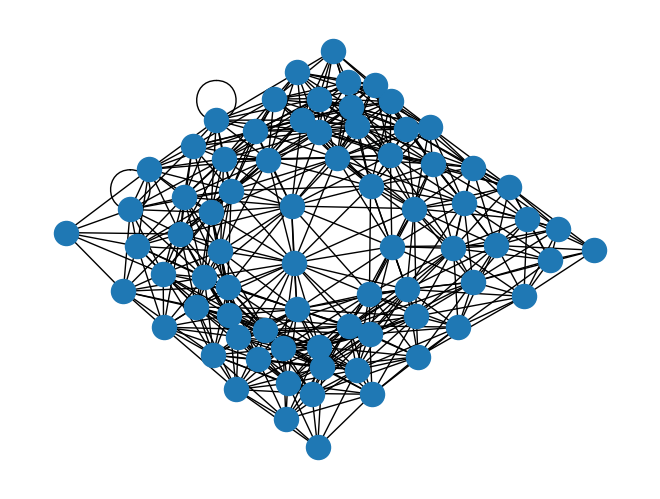

In [67]:
import maha

graph_data = MNISTSuperpixels(root='.')
target = graph_data[1]

_, target_vector = model(target.x, target.edge_index, target.batch)
target_vector = target_vector.detach().cpu().numpy()
target_label = target.y

from torch_geometric.utils import to_networkx
import networkx as nx

x = to_networkx(target, to_undirected=True)
nx.draw(x)

matrix = df.iloc[:, 1:129]
#print(matrix.shape)
cov_matrix = maha.cov_standard(matrix)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
#print(cov_matrix.shape)
diag_matrix = np.diag(eigenvalues)

distances = []
for index, row in df.iterrows():
    label = row[0]
    vec = row[1:]
    #print(vec.shape)
    vec = np.array(vec)
    dist = maha.mahalanobis(target_vector.reshape(-1), vec.reshape(-1), np.linalg.inv(cov_matrix))
    distances.append(dist)

#print(np.sort(distances))

# Resultados
df_result = df.copy()
df_result.insert(1, "Distancias", distances)

df_result.to_csv("Resultados.csv", index=False)

In [72]:
df_result = pd.read_csv("Resultados.csv")

#print(df_result.head())

print(f"Target: {target_label}")

for i in range(10):
    print(df_result.sort_values('Distancias').head(10)['labels'].values[i])


Target: tensor([0])
0
0
3
3
0
3
0
2
2
0
